## Monte Carlo Portfolio Optimization

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
plt.style.use('seaborn-v0_8-dark-palette')
import warnings
warnings.filterwarnings('ignore') 

### 1. Fetch data

In [2]:
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2023-01-01', end='2024-01-01')['Adj Close'] 

[*********************100%%**********************]  2 of 2 completed


### 2. Calculate Daily Returns

In [3]:
returns = data.pct_change().dropna()
returns.head() 

Ticker,AAPL,MSFT
Date,,
2023-01-04,0.010314,-0.043743
2023-01-05,-0.010605,-0.029638
2023-01-06,0.036794,0.011785
2023-01-09,0.004089,0.009736
2023-01-10,0.004456,0.007617


### 3. Compute Expected Returns and Statistics

In [4]:
def rets_stats(returns):
    expected_returns = returns.mean() 
    cov_matrix = returns.cov() 
    skewness = returns.apply(lambda x:skew(x)) 
    kurtoses = returns.apply(lambda x:kurtosis(x))
    return expected_returns, cov_matrix, skewness, kurtoses 

In [5]:
expected_returns, cov_matrix, skewness, kurtoses = rets_stats(returns) 
print('==========Expected Returns==========')
print(expected_returns)
print() 
print('==========Covariance Matrix==========')
print(cov_matrix) 
print()
print('==========Skewness==========')
print(skewness) 
print()
print('==========Kurtosis==========')
print(kurtoses)  

==========Expected Returns==========
Ticker
AAPL    0.001835
MSFT    0.001972
dtype: float64

==========Covariance Matrix==========
Ticker      AAPL      MSFT
Ticker                    
AAPL    0.000158  0.000109
MSFT    0.000109  0.000250

==========Skewness==========
Ticker
AAPL    0.011683
MSFT    0.372527
dtype: float64

==========Kurtosis==========
Ticker
AAPL    1.380288
MSFT    1.396485
dtype: float64


#### 4. Portfolio Variance Function

In [6]:
def portfolio_variance(weights,cov_matrix):
    return np.dot(weights.T,np.dot(cov_matrix,weights)) 

### 5. Portfolio Skewness Function

In [7]:
def portfolio_skewness(weights,skewness,returns):
    # Compute the portfolio returns
    port_returns = np.dot(returns,weights)
    # Calculate and return the skewness of the portfolio returns
    return skew(port_returns) 

### 6. Portfolio Kurtosis Function

In [8]:
def portfolio_kurtosis(weights,kurtoses,returns):
    # Compute the portfolio returns
    port_returns = np.dot(returns,weights) 
    # Calculate and return the kurtosis of the portfolio returns
    return kurtosis(port_returns) 

### 7. Define Utility Function

In [9]:
def utility_function(weights,expected_returns,cov_matrix,skewness,kurtoses,lambd=0.5,gamm=0.5,delt=0.5):
    exp_return = np.dot(weights,expected_returns)
    var = portfolio_variance(weights,cov_matrix) 
    skewness_val = portfolio_skewness(weights,skewness,returns)
    kurtosis_val = portfolio_kurtosis(weights,kurtoses,returns)

    # Utility Function
    utility = exp_return - lambd*var + gamm*skewness_val - delt*kurtosis_val
    return -utility # Negative sign is for minimization  

### 8. Define Constraints

In [10]:
def constraint_sum_weights(weights):
    return np.sum(weights)-1

def constraint_nonnegative(weights):
    return weights # Interpreted as weights >= 0 in constraints

### 9. Optimization

In [11]:
# Initial Weights

num_assets = len(tickers)
initial_weights = np.ones(num_assets)/num_assets

# Bounds and Constraints
bounds = [(0,1) for _ in range(num_assets)] 
constraints = [{'type':'eq','fun':constraint_sum_weights},
               {'type':'ineq','fun':constraint_nonnegative}] 

# Optimization
result = minimize(
    utility_function,
    initial_weights,
    args=(expected_returns, cov_matrix, skewness, kurtoses),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Results
optimal_weights = result.x
print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Utility Value: {-result.fun}") 

Optimal Weights: [0.49641923 0.50358077]
Optimal Utility Value: 0.11458792014366012


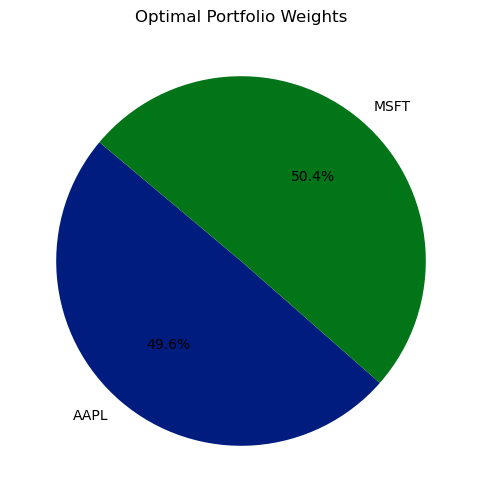

In [12]:
import matplotlib.pyplot as plt 
# Plotting the optimal weights as a pie chart

plt.figure(figsize=(8, 6))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimal Portfolio Weights')
plt.show() 